# Decision Trees for Classification

(beginner's level)

In this tutorial we give a beginner's introduction to the Decision Tree learning which is a supervised algorithm. The Decision Tree models are simple to understand, easy to interpret and convinient to deploy. Although they can be used for both classification and regression, examples in this discussion foucs on classification problems only.  

Being a supervised learning algorithm, the model building in Decision Tree classification includes a training phase where it tries to learn the rules of distinction between classes using examples from the historic data. Each of the training examples consist of values corresponding to a set of descriptory variables called features and with a label that identifies its class.

For long various tree like graphs have been used as decision support systems. A familiar example is how a physician would diagnose an illness based on a series of questions designed around symptoms. But in our current context, the term Decision Tree refers specifically to a Binary Tree data structure thats capable of learning from exposure to data. A modern name for this algorithm is CART which is an acronym for Classification And Regression Trees but we here stick to it's traditional name 'Decision Tree' abbreciated as DT in this tutorial. 

## Representation and Learning

As just said, The DT model is respresented as a binary tree. The binary tree is a succession of records called "nodes". Each node is linked to atmost two successor nodes referred to as its left and right children. 
- The first node at the origin of the tree has no parent and is called "root node" and the terminating nodes that do not have any successors are called "leafs or terminal nodes". 
- In a non-trivial tree, the root node is linked to each leaf through a series of "intermediate nodes". 
- The number of steps between root and the furthest leaf node is called the height of the tree.
- Each non-leaf node in a DT represents a splitting condition based on a single feature variable. Based on how splitting condition evaluates for a data record on the node, the record gets to assigned to either of its children. - This process continues till the record trickles down to a leaf node - each of which is associated with a class label. 

![DTdemo.png](DTdemo.png)

With this simple binary tree representation of trained model, making predictions for new unseen data is straight forward. The new data record would travel through the tree until it ends up on one of the leaf nodes; and the class label of the leaf node assigned as the final resulting label of the new record.  

Now what makes the tree to decide the best 'splitting' and 'stopping' condition? 

### Split Criterion

Finding a best split condition at any node involves identifying which feature to use as well as deciding the boundary of split. For each of the available input feature, all possible split points are evaluated using a cost function with an aim to minimize it. The popular strategies for defining cost function are based on the choices such that each split minimizes the impurity at the child nodes. Most common criteria to measure the quality of a split are:

#### GINI Index

The GINI index for a node measures the impurity. Its defined in a way that its value is minimum when all the records at the node belongs to same class and maximum when each record belongs to a distinct class resulting in 50-50 split of classes in a binary classification problem. In GINI driven DT algorithms, the split condition is chosen to ensure that overall impurity after the split is as less possible as than the impurity at parent node. 
- The calculation of GINI index is quite simple - subtract the sum of the squared probabilities of each class from one.  

#### Information Gain

The information gain is based on the decrease in entropy after a split on an attribute of training dataset. The Entropy at a node is a measure of randomness in its data. Constructing a decision tree is all about finding feature that returns the highest information gain (i.e., the most homogeneous branches).
- It is calculated as multiplication of the probability of the class times the log of that class probability. 


### Stopping Criterion

The DT learning needs to know when to stop splitting as it works its way down the tree with training data. 
- An obvious idea is to reject a split if number of data records at any of the children-node is less than some threshold. This way a particular branch would stop growing once this condition of minimum number of data records in terminal node is met.
- Another idea is to pre-define the maximum depth of the tree i.e. the maximum number of nodes from the root node of the tree. Once this condition of maximum depth of the tree is met, further splitting into new nodes must stop.

Without such stopping requirements, the tree might grow deep and complex, resulting into ovefit the training data (overfit problem - discussed later in this section).

## A Working Example

In this section we show how to use DT classifier from scikit-learn package. For purpose of this demonstration we use the wine quality dataset from [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/) which is clean, simple and very popular in Machine Learning circles. Some of the readers might already know about this dataset but anyone interested in further details can refer [this](http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality.names) link. Please note that one does n't need to worry too much about the domain specific importance of features in order to work through this example.

We are using the white-wine dataset with 12 columns of which the one named **quality** is the grade **(0=Very Bad, 1=Excellent)** given by experts to the sample and its our target. Rest of the columns are various features like **Fixed Acidity, Volatile Acidity, Residual Sugar etc.** that desribe physico-chemical and sensory characteristics of the wine. Our aim is to to see if we can train a Decision Tree model to predict the quality using some or all of the feature variables. 


### Loading the Dataset

In [1]:
#Load the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# get the data and create dataframe
fName = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
df = pd.read_csv(fName , sep = ';')

In [2]:
from IPython.display import display, HTML
HTML (df.head(5).to_html())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Data Exploration and Preparation
Ideally a Data Scientist starts with a thorough exploration of the features, correlations and patterns. This is called Exploratory Data Analysis (EDA) and is the most important phase in life cycle of a real world bussiness analysis. One of the major goals of EDA is pre-processing the data might need before it could be used for building models. Since we want to keep DT classification in sharp focus we will avoid a very detailed EDA and confine to simple tasks that are barely necessary. 

1. Outlier Removal.
2. Target Binarization
3. Feature Selection.

Although EDA we do here is sufficient for the purposes of this tutorial but it by no means exhaust the list of what can be done. If you are interested in really detailed exploration and understanding of the feature set, please follow this [link](https://www.datacamp.com/community/tutorials/deep-learning-python).
#### Outlier Removal
Let us first look into distributions like density and box plots for some of the features.

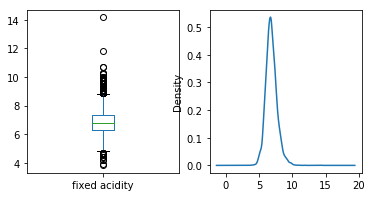

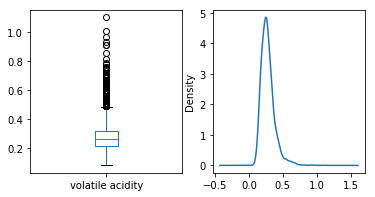

In [3]:
feature_list = list(df.columns[0:2])
for col in feature_list:
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6,3))
    df[col].plot(kind='box', ax = ax1)
    df[col].plot(kind='density', ax = ax2)
    plt.show()

An outlier is an observation that appears to deviate markedly from other observations in the sample. Identification of potential outliers is important because they may indicate wrong or highly unusual pattern - and may have unfair influence on training process. 

After looking into box/density plots like shown above, we can notice that almost all the features in this dataset has some outliers.

There are several approaches on dealing with this issue but we follow the simplest one by removing the records containing outlying feature values. 

In [4]:
def remove_outliers(df_in, col_name):
        q1 = df_in[col_name].quantile(0.25)
        q3 = df_in[col_name].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
        return df_out
    
#Outlier Removal
feat = list(df.columns[:-1])
for col in feat:
    df = remove_outliers(df, col)


#### Binarization of target 
The target quality is a multi-level variable assuming values 1 through 10. In order to keep simple we convert it into a binary label with values 0 and 1 respectively indicating excellent or poo wine-quality. The folding logic is implemented in function Taste below:

In [5]:
def Taste(quality):
    # If quality > 5, its a good wine.
    # If quality < 5, its a poor wine.
    if quality > 5:
        return 0 #good
    else:
        return 1 #bad
df['quality'] = df['quality'].apply(Taste)
print(df.quality.value_counts())    #print number of good and bad samples

0    2784
1    1167
Name: quality, dtype: int64


#### Feature Selection
In this section we will show how to identify highly correlated features and drop them from the model since they don't contribute any additional information. Dropping these encourages simplicity, performance of the model as well reduces the computational effort. 

In [18]:
import itertools

#Obtain the correlation Matrix
corr = df.corr().abs() 

#Obtain unique feature combinations.
all_pairs = list(itertools.combinations(corr,2))

#Return pair->correl_coeff for correl_coeff>0.4
corr_vals = [ [(i,j),corr.loc[i,j]] for i,j in all_pairs if corr.loc[i,j]>0.4]

#For printing ease, convert to DataFrame and add column headers
corr_vals = pd.DataFrame(corr_vals,columns=['Feature Pair','Pearson Correlation Coefficient (Absolute)'] )

#Render using HTML
HTML(corr_vals.to_html())

,Feature Pair,Pearson Correlation Coefficient (Absolute)
0,"(residual sugar, total sulfur dioxide)",0.413257
1,"(residual sugar, density)",0.844136
2,"(residual sugar, alcohol)",0.493852
3,"(chlorides, density)",0.511490
4,"(chlorides, alcohol)",0.556369
5,"(free sulfur dioxide, total sulfur dioxide)",0.620374
6,"(total sulfur dioxide, density)",0.554086
7,"(total sulfur dioxide, alcohol)",0.477305
8,"(density, alcohol)",0.822894


Note that **density**, **residual sugar**, **total sulfur dioxide** and **alcohol** appear most often in high correlation pairs. Hence we will drop these features except **alcohol**. 

In [7]:
#Features Dataset
X = df.drop(['quality', 'total sulfur dioxide', 'density', 'residual sugar'], axis=1)

#Target Dataset
y = df['quality']

### Test and Training Sets
Below we split the feature and target sets into training and testing subsets.

In [8]:
from sklearn.model_selection import train_test_split

#Split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=21)

### Training the Classifier
We now are almost ready to train the Decision Tree classifier but before we do that we need to perform feature scaling. Feature scaling standardizes the range of features so that the ones with higher number scales don't have undue influence on how the model trains. Below we create a pipeline that performs following actions in order:

1. Apply feature scaling using StandardScaler from scikit-learn.
2. Create a DecisionTreeClassifier and fit to the training data.


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

# What the steps ?
steps = [('scaler', StandardScaler()),('dtc', DecisionTreeClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)


# Fit the pipeline to the training set
dtc_scaled = pipeline.fit(X_train, y_train)

### Testing the Classifier
Now that we already have created a trained classifier, we will use the test set created above to obtain predicted values of **quality** label. Subsequently we will compare these predictions with truth values in order to quantify the performance of our classifier. Note that the test set is disjoint to the dataset used for training the classifier- its important in order to ensure unbiased measurement of model performance.

#### Evaluating the performance
Although we would like our ML models to always provide correct answers, but like everything else in life, they too can make mistakes. In context of our example these mistakes be grouped as follows:

1. Type 1 Error : The trained DT gives label poor to a wine that is actually good.
2. Type 2 Error : The trained DT gives label excellent to a wine thats actually poor.

Model performance is usually quantified with metrics like precision, recall, f1-score which are computed by comparing predicted values of target to the true ones. For this tutorial, we rely on model sensitivity or recall score which measures how often the classifier correctly identifies the bad quality wine-samples. This could be an important information for a winery in order to ensure that only best tasting of its samples are released into the market.

In [10]:
from sklearn.metrics import classification_report

# Compute and print metrics
y_pred_scaled = dtc_scaled.predict(X_test)
print(classification_report(y_test, y_pred_scaled))

             precision    recall  f1-score   support

          0       0.83      0.84      0.83      1107
          1       0.61      0.60      0.61       474

avg / total       0.76      0.77      0.77      1581



In the classification report above we see that of all the wine-samples labelled as bad just a little over half (61%) are actually bad (precision). Similarly, off all the bad wine-samples in test set, the model could identify only (60%) as bad. We must note here that while its great to witness the ability of decision tree to correctly identify the wine-quality in so many cases, the performance metrics are not exactly flattering.

In rest of the tutorial we talk about problems that can adversely affect the classifier's performance and also discuss methods to tackle them. For starters lets begin by asking how complex is the our trained DT classifier i.e What is the total number of Nodes ?

In [11]:
#Find numNodes, maxDepth of Classifier
n_nodes   = dtc_scaled.named_steps['dtc'].tree_.node_count
max_depth = dtc_scaled.named_steps['dtc'].tree_.max_depth 

#Print to the screen, use Dataframes for nice aesthetics
dfx = [[n_nodes,max_depth]]
dfx = pd.DataFrame(dfx,columns=['Number of Nodes', 'Maximum Depth'])
HTML('<br>'+dfx.to_html()+'<br>')

,Number of Nodes,Maximum Depth
0,759,19


We see above that node of maximum depth in DT is 19 layers deep which is arguably too much for a dataset with 12 features only. Rest of this tutorial will examine the reasons for this complexity, and discuss what can we do to controll them.

### Optimizing the Classifier against Statistical Noise
Every dataset contains random noise on account of statistical fluctuations or irreducible error. A good model is the one that seeks to learn systematic mapping between the features and neglects the noise. A situation when model treats the statistical noise in training sample as a valid pattern is called Overfitting. It is a problem, because statistical noise in training set is unique to it and adversely affects the model's performance on test samples since they have their own noise patterns. Algorithmically this happens when a learner tree continues to go deeper and deeper in splitting, building several branches just because of outliers and other irregularities in data. One of the ways to counter this is to reduce the complexity of DT by pruning sections that provide little power to classify.

#### Pruning
Pruning the DT can help supress the effects of overfitting by enforcing some measures of simplicity that prevent tree from growing too deep and complex. The scikit-learn provides several customizable parameters to constrain how the tree grows during training phase. Here's a few of them:

1. **max_depth** : The maximum depth allowed to final tree.
2. **min_samples_split**: Minimum number of samples required to split an internal node.
3. **min_samples_leaf** : Minimum number of samples required to be at a leaf node.
4. **max_features** : Number of features to consider when looking for the best split.
5. **min_impurity_decrease**: Minimum decrease of the impurity to allow a split.
6. **min_impurity_split** : A node will split if its impurity is above the threshold, otherwise it is a leaf.

While its awesome to have so many controllable parameters but arriving at at optimal combination can be rather tedious. We below show how to arrive at 'best' value of a **"max_depth"** by doing search over a grid of several possible values.

##### Create parameter grid

In [12]:
#Choose search points in parameter space
parameters = { "dtc__max_depth": [x for x in range(1,21)]}

##### Perform search using GridSearchCV
Below we setup a grid search by specifying the model (**pipeline**), grid (**parameters**) and scoring (**scoring='recall'**) parameters. In current configuration we will end up with a trained model with a value **max_depth** from grid that maximizes the recall.  

In [19]:
from sklearn.model_selection import GridSearchCV

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters, scoring='recall',return_train_score=True)

# Fit to the training set
cv.fit(X_train, y_train)
print('')

##### Testing the Optimized Classifier
Now its time to see how the optimized classifier performs:

In [14]:
# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.85      0.77      0.80      1107
          1       0.55      0.67      0.61       474

avg / total       0.76      0.74      0.74      1581



We see that the recall is 7% higher in optimized classifier compared to the default one. This comes at cost of precision, but it could be acceptable since not letting bad samples into the market is often bigger goal.   

#### Understanding the Gridsearch
We now take a step back and understand the working of GridSearch mechanism. As seen above we begin by creating a grid of possible values the parameter can assume. The search mechanism successively sets parameter equal to different points on the grid and evaluates the the performance each time. The performance evaluation is done by performing k-fold cross-validation as follows:

** K-Fold Cross Validation **:
* Split the dataset into k-folds
* Hold back 1 fold as test set, and use rest (k-1) folds for training
* Using test set, evaluate the model performance. 
* Repeat above two steps until each fold has acted as test set
* At the end, we end up with 'k' performance scores- one for each fold 
* Find the mean,stddev of performance score  

The k-fold validation gives better results because the algorithm is trained and evaluated multiple times on different data. After all the values on parameter grid have been visited by search algorithm, it picks out the one that maximizes the **performance score** to be used as the **optimal** point.

Below we show how to access the mean and standard deviation of **perfromance score** at each point on the parameter grid.  

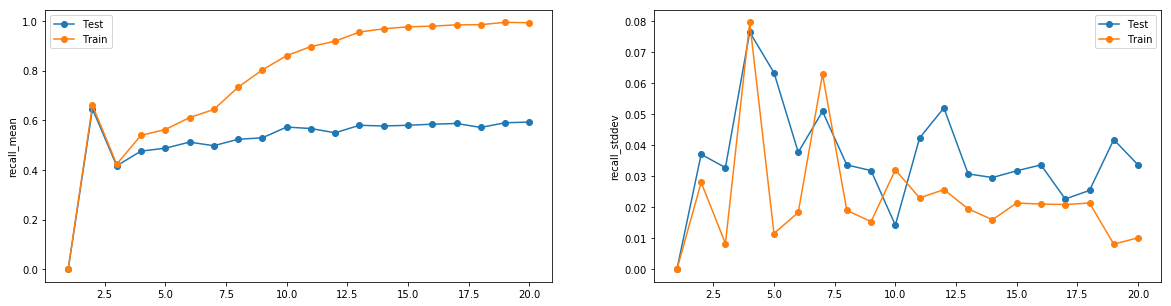

In [15]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
#Lets plot the graph of max depth vs recall
depth_val = []
score_val = []
#for a in cv.cv_results_: print (a)
tran_scores = cv.cv_results_['mean_train_score']
test_scores = cv.cv_results_['mean_test_score']

tran_std = cv.cv_results_['std_train_score']
test_std = cv.cv_results_['std_test_score']


test_points = cv.cv_results_['param_dtc__max_depth']


ax1.plot(test_points,test_scores, marker='o', label = "Test")
ax1.plot(test_points,tran_scores, marker='o', label = "Train")

ax2.plot(test_points,test_std, marker='o', label = "Test")
ax2.plot(test_points,tran_std, marker='o', label = "Train")

ax1.set_ylabel('recall_mean')
ax2.set_ylabel('recall_stddev')

ax1.legend()
ax2.legend()
plt.show()

You can notice in this plot that as you keep on increasing the model depth the sensitivity score for training sample is increasing but the test score is not following the same trend. 
This shows us that training sample is picking up all noises from the train sample and is not able to generalize it's predictions on unseen test sample. Also note that the number of nodes increases with increase in tree depth i.e. tree complexity is directly propotional to tree depth. So, it's better to keep the tree simple by restricting the tree depth to 2 (gives test score). 

### Visualizing the Trained DT

A great advantage with DT is how easily they could be visualized and interpretted. 
We can easily export the trained tree in [Graphviz (a visulization software)](http://www.graphviz.org/) format using the [export_graphviz exporter](http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html) and visulize the set of rules alongwith gini or entropy score and training records in each node. 

First we show the pruned tree as it is simple to understand:

0    1677
1     693
Name: quality, dtype: int64


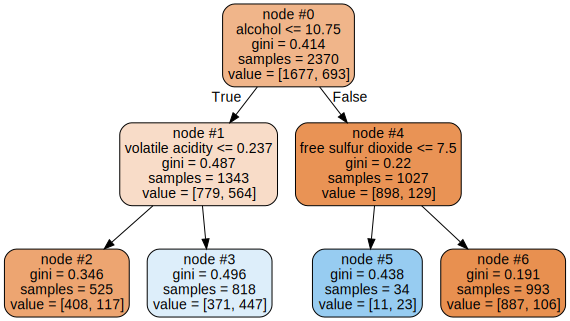

In [16]:
print(y_train.value_counts())           #to check the number of good and bad quality samples
dtc = DecisionTreeClassifier(max_depth=2)
dtc.fit(X_train, y_train)
import graphviz
import pydot 
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
dot_data = export_graphviz(dtc, feature_names =X.columns[:], leaves_parallel = True,
                           node_ids = True, filled=True, rounded=True,out_file=None, 
                           max_depth = 3)
graphviz.Source(dot_data) 

As can be seen from above picture, root node (node-0) checks if alcohol content in white wine is less than or more than 10% and classifies the training subset that has 1677 good and 693 bad quality wine samples. It ends with two child nodes which are not so pure given gini score in them. 

But note that our purpose here is just to get a data driven model that has a simple set of rules to predict the class for a new sample.

Below let us visulize the unpruned complex tree that we trained before just for the purpose of getting a notion of how complex the tree was. Since this is more than 1000 nodes tree, while plotting we have restricted the depth to be 3. 

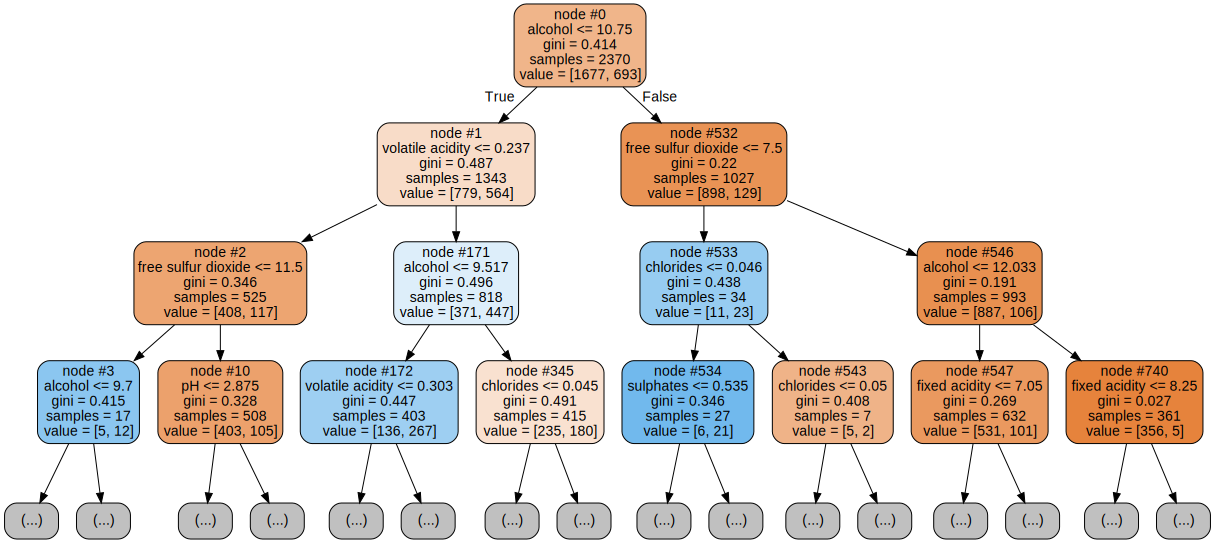

In [17]:
dtc_complex = DecisionTreeClassifier()
dtc_complex.fit(X_train, y_train)
import graphviz
import pydot 
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
dot_data = export_graphviz(dtc_complex, feature_names =X.columns[:], leaves_parallel = True,
                           node_ids = True, filled=True, rounded=True,out_file=None, 
                           max_depth = 3)
graphviz.Source(dot_data) 

## Advantages and Disadvantages 

We have seen that Decision Trees algorithms have several advantages. 

1. Decision Trees are easy to explain as they result in a set of simple decision rules.
2. It follows the same approach as humans generally follow while making decisions.
3. Interpretation of a Decision Tree model can be simplified by its visualizations.
4. Unlike several other alogrithms DT can handle huge data sets with mixed predictors.
5. Can easily ignore the redundant variables and help in selecting best features.
6. Handle missing data elegantly.

These are definitely huge positives especially while working in commerical environment where not all the stake holders are either interested or capable of understanding complex modeling approaches. But decision trees have some very prominent disadvantages too:

Disadvantages:

1. Very high probability of overfitting as noticed in above plots.
2. Generally, DTs have lower prediction accuracy compared to other machine learning algorithms.
3. Can be unstable because small variations in datasets can result in completely different trees, but ensemble of DTs can help here.
4. Calculations can become complex when there are many class labels. 
   - You can try to check this with a simple change in above tutorial, just do not use the function "Taste".
5. For imbalanced classes, DTs can be biased towards dominating classes. So, dataset should be balanced prior to train the DT model. 
   - You can check this by yourself, just set the quality for pure class to be more than 7 and redo the tutorial.

## Enhancing Decision Trees

The plain vanila DT learners are simple but often not very useful in real life situations. Several variations of DTs have been developed to overcome the disadvantages and achieve robust and powerful classification algorithms. This simple algorithm provides a base for several ensemble methods like bagging, random forests and boosting that we will discuss in separate tutorial.